In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import torch
import random
import pickle
import numpy as np
import scanpy as sc

import NEXUS
from NEXUS.data_process.data_process_sample import creat_adata_graph, Adata_to_graph, creat_graph_adata 
from NEXUS.sample_emb.Graph_model import GraphVAE, train_model, embedding, loss_function

# 设置随机种子以保证可复现性
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [3]:
# 需要的参数及定义
random_seed = 42
input_path = "../test_data/1_cell_emb_output/VAE_embedded.h5ad"
output_path = "../test_data/2_graph_emb_output/"

if not os.path.exists(output_path):
    os.makedirs(output_path)

sample_id = 'sample_ID'
labels = ['sample', 'cluster']
pooling_type = 'mean'
split_ratio = 0.9
batch_size = 10
input_dim = 64
hidden_dim = 64
latent_dim = 32
heads = 4
edge_dims = 1 

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

In [4]:
### 读取并构建adata
adata = sc.read_h5ad(input_path)
adata, class_num = creat_adata_graph(adata, sample_id)

In [5]:
adata_to_graph = Adata_to_graph(adata, labels, split_ratio, batch_size)
adata = adata_to_graph.label_meta()
adata_to_graph.get_graph_dataset()
graph_dataset, train_loader, test_loader = adata_to_graph.dataloader()
adata.write(output_path + 'cell_embedded_adata.h5ad')

In [6]:
# 模型定义
model = GraphVAE(input_dim, hidden_dim, latent_dim, class_num, pooling_type = pooling_type, heads = heads, edge_dims = edge_dims)
model = model.to(device)

In [7]:
train_model(model, train_loader, test_loader, loss_function, fine_tune=False, device = device)
del train_loader, test_loader

Epoch 1/500, Train Loss: 2.4136, Train Acc: 0.0769
Contrastive Loss: 1.3178, Edge Prediction Loss: 2.2860
Test Loss: 1.0195, Test Acc: 0.0000
Epoch 2/500, Train Loss: 2.2971, Train Acc: 0.0769
Contrastive Loss: 1.3878, Edge Prediction Loss: 2.0635
Test Loss: 0.9872, Test Acc: 0.0000
Epoch 3/500, Train Loss: 2.1725, Train Acc: 0.0769
Contrastive Loss: 1.4469, Edge Prediction Loss: 2.0039
Test Loss: 0.9444, Test Acc: 0.0000
Epoch 4/500, Train Loss: 1.9581, Train Acc: 0.0769
Contrastive Loss: 1.0215, Edge Prediction Loss: 1.3269
Test Loss: 0.8929, Test Acc: 0.0000
Epoch 5/500, Train Loss: 1.7181, Train Acc: 0.0769
Contrastive Loss: 0.5369, Edge Prediction Loss: 1.4471
Test Loss: 0.8068, Test Acc: 0.0000
Epoch 6/500, Train Loss: 1.5466, Train Acc: 0.0769
Contrastive Loss: 0.5091, Edge Prediction Loss: 1.1110
Test Loss: 0.6860, Test Acc: 0.0000
Epoch 7/500, Train Loss: 1.3659, Train Acc: 0.0769
Contrastive Loss: 0.6777, Edge Prediction Loss: 1.3137
Test Loss: 0.5470, Test Acc: 0.0000
Epoch 

In [8]:
embedded_dataset = embedding(model, graph_dataset, device = device)

In [9]:
with open(output_path + "Graph_embedded.pickle", "wb") as file:
    pickle.dump(embedded_dataset, file)

model = model.to('cpu')
torch.save(model, output_path + "Graph_VAE_model.pt")

### 构建 graph_adata

In [10]:
# 需要定义的参数
strong = False
meta_label = ["sample_ID", "sample_cluster", "sample_num", "cluster_num"]
file_path = "../test_data/2_graph_emb_output/"

In [11]:
adata = creat_graph_adata(file_path, meta_label, strong)

F:\Anaconda\envs\NEXUS\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
F:\Anaconda\envs\NEXUS\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
F:\Anaconda\envs\NEXUS\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
adata.write(file_path + 'graph_embedded_adata.h5ad')

In [13]:
import scanpy as sc
import NEXUS
from NEXUS.plotting.emb_plot import sample_embedding_umap_plot

In [14]:
adata = sc.read_h5ad("../test_data/2_graph_emb_output/graph_embedded_adata.h5ad")

In [15]:
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)

In [16]:
sc.pp.neighbors(adata, n_neighbors = 8, use_rep="X_pca")
sc.tl.umap(adata)

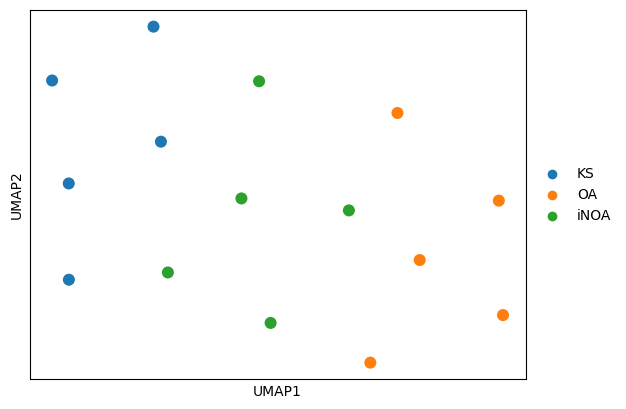

In [17]:
sc.pl.umap(adata, color = "sample_cluster", size = 300, title=""
          )